# 一次元浅水流計算における合流による水位上昇量の計算方法

## 導入

[「河道計画検討の手引き」に示される合流による水位上昇の計算方法](http://www.jice.or.jp/cms/kokudo/pdf/tech/material/kadoukeikaku.pdf#page=90)について解説します。
この手法は、[室田 明, 多田 博登:一次元水面形解析における合流点モデルに関する研究](https://www.jstage.jst.go.jp/article/jscej1984/1989/405/1989_405_129/_article/-char/ja/)が元になっています。

## 計算式

合流による水位上昇量の計算方法の概要を以下に示す。

手引と同様に合流後河道の流向軸の運動量保存則は以下のとおりとなる。
コントロールボリュームの考え方が若干複雑なため、詳細は元論文を参考にされたい（時間ができたときにまとめます）。

$$
\begin{align}
& \beta \rho Q_2 \frac{Q_2}{B_2h_2}\cos \theta _2 + \beta \rho Q_1 \frac{Q_1}{B_1h_1}\cos \theta _1-\beta \rho Q_3 \frac{Q_3}{B_3h_3}\cos \theta _3 \\
& = B_3\frac{1}{2}\rho g {h_3}^2 - B'_2 \cos \theta _2 \frac{1}{2}\rho g {h_2}^2 - B'_1 \cos \theta _1 \frac{1}{2}\rho g {h_1}^2 
\end{align}
$$

ここに、$\rho$：水の密度、$g$：重力加速度、$Q$：流量、$B$：水路幅、$h$：水深、$\theta$：合流角度（下図参照）、$\beta$：運動量補正係数、$B'$：修正した川幅（下図参照）、添字1,2,3は河道1,2,3（下図参照、ここでは1：本川、2：支川とする）の諸量である。

![A](conf.png)

元論文のとおり$h_1=h_2$を条件として式変形を行うと以下のとおりとなる。

$$
\begin{align}
&\left(\frac{B'_2}{B_3}\cos \theta _2 + \frac{B'_1}{B_3}\cos \theta _1\right)\left(\frac{h_1}{h_3}\right)^3-(1+2\beta {Fr}^2)\frac{h_1}{h_3}\\
&\hspace{20mm}+2 \beta \left\{\left(\frac{Q_2}{Q_3}\right)^2 \frac{B_3}{B_2}\cos \theta _2+\left(\frac{Q_1}{Q_3}\right)^2 \frac{B_3}{B_1}\cos \theta _1\right\}{Fr}^2=0\\
\end{align}
$$

ここに、フルード数${Fr}^2=\dfrac{{Q_3}^2}{g{B_3}^2{h_3}^3}$とする。


$$
\begin{align}
X&=\dfrac{h_1}{h_3}=\dfrac{h_2}{h_3}&\\
\alpha &= \left(\frac{B'_2}{B_3}\cos \theta _2 + \frac{B'_1}{B_3}\cos \theta _1\right)&\\
\gamma &= \left\{\left(\frac{Q_2}{Q_3}\right)^2 \frac{B_3}{B_2}\cos \theta _2+\left(\frac{Q_1}{Q_3}\right)^2 \frac{B_3}{B_1}\cos \theta _1\right\}
\end{align}
$$

として整理すると、

$$
\begin{align}
X^3-\frac{1+2\beta {Fr}^2}{\alpha}X+ \frac{2 \beta \gamma {Fr}^2}{\alpha}=0
\end{align}
$$

のとおり、$X$の三次方程式となる。これを解くことによって水位上昇量を計算する。

なお、元論文では$\alpha=1$（角度補正した合流前川幅の和が合流後川幅と等しい）を前提条件としているが、前出の手引には記載されていない。

本記事では簡易的に$\alpha=1$、$\beta=1$として水位上昇量$X$の計算を行った。

## テスト計算 

### 計算モデル


 - 三次方程式はnp.rootsで解く。
 - 上記の解のうち、実数かつ1以上（水位上昇量のため）のものを水位上昇量とする。
 - 正しい条件を与えると解は1または0個になる。

参考 三次方程式の計算方法：https://west-village-tech.com/cubic_equation/

In [ ]:
import numpy as np

In [ ]:
def caldhConfluence(Q1Q3 ,Q2Q3 ,B3B1 ,B3B2 ,Theta1 ,Theta2 ,Fr):
    
    g = (Q2Q3)**2*B3B2*np.cos(Theta2*np.pi/180) \
     +  (Q1Q3)**2*B3B1*np.cos(Theta1*np.pi/180)
    
    x = np.roots([1,0,-1-2*Fr**2,2*g*Fr**2])
    
    # 実数のみ抽出
    x2 = x[np.iscomplex(x)==False]
    # 水位上昇量なので1以上のみ
    x3 = x2[np.where(x2>=1.0)]
    
    if len(x3) == 0:
        ans = np.nan
    elif len(x3) == 1:
        ans = x3[0].real
    else:
        print('error')
        ans = np.nan
    return ans

### 合流角度および合流前流量比の感度分析

合流角度は以下の3ケースを設定する。


$$
\begin{array}{l:c:c}
\mathrm{Case} & \theta_1[\mathrm{deg}]    & \theta_2[\mathrm{deg}] \\ \hline
\mathrm{Case A}  &  10  &  10 \\ 
\mathrm{Case B}  &  45  &  45 \\ 
\mathrm{Case C}  &  0   &  90 \\ 
\end {array}
$$

合流前流量比は以下の3ケースを設定する。また、川幅はRegime theory($B = 5 \sqrt{Q}$)により設定する。よって、式中の係数は以下のとおりとなる。


$$
\begin{array}{l:c:c:c:c:c}
\mathrm{Case} & Q_1:Q_2 & Q_1/Q_3 & Q_2/Q_3 & B_3/B_1 & B_3/B_2 \\ \hline
\mathrm{Case1} & 1:1 & 1/2 & 1/2 & \sqrt{2} & \sqrt{2}  \\
\mathrm{Case2} & 2:1 & 2/3 & 1/3 & \sqrt{3/2} & \sqrt{3}  \\
\mathrm{Case3} & 5:1 & 5/6 & 1/6 & \sqrt{6/5} & \sqrt{6}  \\
\end {array}
$$


これらを組み合わせ9ケースについて合流後のフルード数を0.1～1.0まで変化させた場合の水位上昇量の計算結果を以下に示す。

これらより、以下の点が確認できる。

 - フルード数が大きい程水位上昇量が大きい
 - 合流角度が大きい程水位上昇量が大きい。（CaseA,B）
 - 合流流量比は1:1に近い程水位上昇量が大きい。
 - 直角合流CaseCの場合、合流流量が大きいCase1では水位上昇量は大きいが、Case3で相対的に水位上昇量が小さくなっている。

In [ ]:
Fr = np.arange(0.1,1.01,0.1)

Q1Q3=1/2
Q2Q3=1/2
B3B1=np.sqrt(2)
B3B2=np.sqrt(2) 
dhoutA1 = [caldhConfluence(Q1Q3,Q2Q3,B3B1,B3B2,Theta1=10 ,Theta2=10 ,Fr=f) for f in Fr]
dhoutA2 = [caldhConfluence(Q1Q3,Q2Q3,B3B1,B3B2,Theta1=45 ,Theta2=45 ,Fr=f) for f in Fr]
dhoutA3 = [caldhConfluence(Q1Q3,Q2Q3,B3B1,B3B2,Theta1=0 ,Theta2=90 ,Fr=f) for f in Fr]

In [ ]:
Q1Q3=2/3
Q2Q3=1/3
B3B1=np.sqrt(3/2)
B3B2=np.sqrt(3) 
dhoutB1 = [caldhConfluence(Q1Q3,Q2Q3,B3B1,B3B2,Theta1=10 ,Theta2=10 ,Fr=f) for f in Fr]
dhoutB2 = [caldhConfluence(Q1Q3,Q2Q3,B3B1,B3B2,Theta1=45 ,Theta2=45 ,Fr=f) for f in Fr]
dhoutB3 = [caldhConfluence(Q1Q3,Q2Q3,B3B1,B3B2,Theta1=0 ,Theta2=90 ,Fr=f) for f in Fr]

In [ ]:
Q1Q3=5/6
Q2Q3=1/6
B3B1=np.sqrt(6/5)
B3B2=np.sqrt(6) 
dhoutC1 = [caldhConfluence(Q1Q3,Q2Q3,B3B1,B3B2,Theta1=10 ,Theta2=10 ,Fr=f) for f in Fr]
dhoutC2 = [caldhConfluence(Q1Q3,Q2Q3,B3B1,B3B2,Theta1=45 ,Theta2=45 ,Fr=f) for f in Fr]
dhoutC3 = [caldhConfluence(Q1Q3,Q2Q3,B3B1,B3B2,Theta1=0 ,Theta2=90 ,Fr=f) for f in Fr]

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='paper', palette="bright", style="whitegrid", font_scale=0.9)

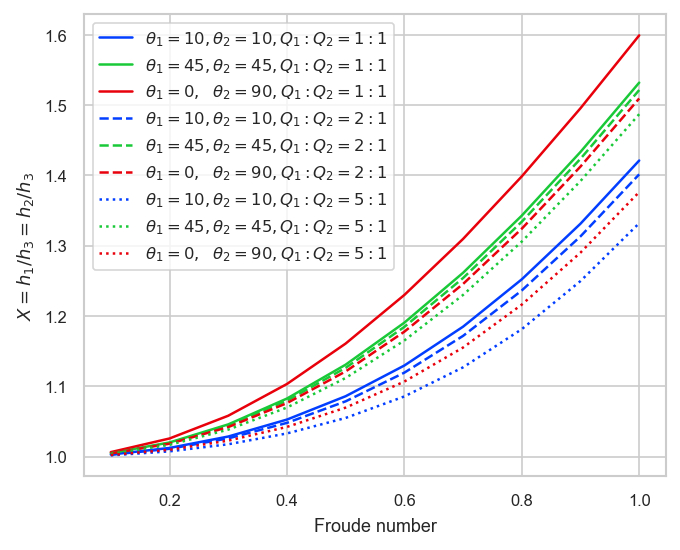

In [7]:
%matplotlib inline
fig = plt.figure(figsize=(5, 4), dpi=150)
ax = fig.add_subplot() 
ax.plot(Fr,dhoutA1, label='$ \\theta_1 =10,\\theta_2 =10, Q_1:Q_2=1:1$'         , c='b', ls='-')
ax.plot(Fr,dhoutA2, label='$ \\theta_1 =45,\\theta_2 =45, Q_1:Q_2=1:1$'         , c='g', ls='-')
ax.plot(Fr,dhoutA3, label='$ \\theta_1 = 0,\,\,\,\, \\theta_2 =90, Q_1:Q_2=1:1$', c='r', ls='-')

ax.plot(Fr,dhoutB1, label='$ \\theta_1 =10,\\theta_2 =10, Q_1:Q_2=2:1$'         , c='b', ls='--')
ax.plot(Fr,dhoutB2, label='$ \\theta_1 =45,\\theta_2 =45, Q_1:Q_2=2:1$'         , c='g', ls='--')
ax.plot(Fr,dhoutB3, label='$ \\theta_1 = 0,\,\,\,\, \\theta_2 =90, Q_1:Q_2=2:1$', c='r', ls='--')

ax.plot(Fr,dhoutC1, label='$ \\theta_1 =10,\\theta_2 =10, Q_1:Q_2=5:1$'         , c='b', ls=':')
ax.plot(Fr,dhoutC2, label='$ \\theta_1 =45,\\theta_2 =45, Q_1:Q_2=5:1$'         , c='g', ls=':')
ax.plot(Fr,dhoutC3, label='$ \\theta_1 = 0,\,\,\,\, \\theta_2 =90, Q_1:Q_2=5:1$', c='r', ls=':')

ax.set_xlabel('Froude number')
ax.set_ylabel('$X=h_1/h_3=h_2/h_3$')
# ax.set_title('$Q_1:Q_2=1:1$')
ax.legend()
plt.show()

### 合流前川幅の感度分析

次に川幅の影響について感度分析を行った。

ケースとして、合流前川幅がRegime theory($B = 5 \sqrt{Q}$)の1.2倍、0.8倍を設定した。

式中の係数は以下のとおりとなる。ここでは、$Q_1:Q_2=1:1$のみとした。


$$
\begin{array}{l:c:c:c:c:c}
\mathrm{Case} & B_1,B_2 &  Q_1:Q_2 & Q_1/Q_3 & Q_2/Q_3 & B_3/B_1 & B_3/B_2 \\ \hline
\mathrm{Case I}                                 & \mathrm{by\,Regime\,theory}\,\times\,1.0 & 1:1 & 1/2 & 1/2 & \sqrt{2} & \sqrt{2}  \\
\mathrm{Case I\hspace{-1.2pt}I}                 & \mathrm{by\,Regime\,theory}\,\times\,1.2 & 1:1 & 1/2 & 1/2 & \dfrac{5\sqrt{2}}{6} & \dfrac{5\sqrt{2}}{6}   \\
\mathrm{Case I\hspace{-1.2pt}I\hspace{-1.2pt}I} & \mathrm{by\,Regime\,theory}\,\times\,0.8 & 1:1 & 1/2 & 1/2 & \dfrac{5\sqrt{2}}{4} & \dfrac{5\sqrt{2}}{4}   \\
\end {array}
$$

これらについて合流後のフルード数を0.1～1.0まで変化させた場合の水位上昇量の計算結果を以下に示す。

これらより、以下の点が確認できる。

 - 合流前川幅が大きいほど水位上昇量が大きくなる。これは流速が小さくなるためである。
 - 合流前川幅を小さくする場合、本計算条件では約0.7倍以下で$X$が1以下、つまり水位が上昇しない条件になる(本モデルではnanを返す)。これは、合流前の流れが射流になるためである。

In [8]:
Fr = np.arange(0.1,1.01,0.1)

Q1Q3=0.5
Q2Q3=0.5
B3B1=np.sqrt(2)
B3B2=np.sqrt(2)
dhout1 = [caldhConfluence(Q1Q3,Q2Q3,B3B1,B3B2,Theta1=10 ,Theta2=10 ,Fr=f) for f in Fr]

B3B1=5/6*np.sqrt(2)
B3B2=5/6*np.sqrt(2)
dhout2 = [caldhConfluence(Q1Q3,Q2Q3,B3B1,B3B2,Theta1=10 ,Theta2=10 ,Fr=f) for f in Fr]

B3B1=5/4*np.sqrt(2)
B3B2=5/4*np.sqrt(2)
dhout3 = [caldhConfluence(Q1Q3,Q2Q3,B3B1,B3B2,Theta1=10 ,Theta2=10 ,Fr=f) for f in Fr]

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='paper', palette="bright", style="whitegrid", font_scale=0.9)

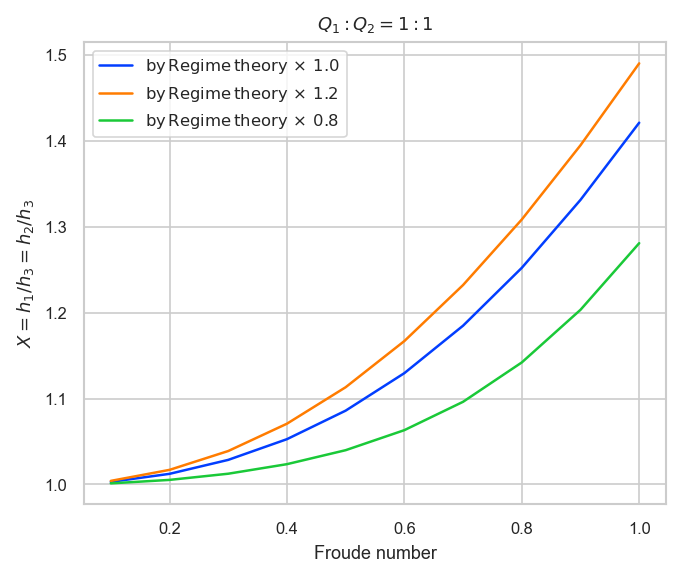

In [10]:
%matplotlib inline
fig = plt.figure(figsize=(5, 4), dpi=150)
ax = fig.add_subplot() 
ax.plot(Fr,dhout1, label='$\mathrm{by\,Regime\,theory}\, \\times \,1.0$')
ax.plot(Fr,dhout2, label='$\mathrm{by\,Regime\,theory}\, \\times \,1.2$')
ax.plot(Fr,dhout3, label='$\mathrm{by\,Regime\,theory}\, \\times \,0.8$')

ax.set_xlabel('Froude number')
ax.set_ylabel('$X=h_1/h_3=h_2/h_3$')
ax.set_title('$Q_1:Q_2=1:1$')
ax.legend()
plt.show()